# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [12]:
# ! pip install "tensorflow==1.14"

In [1]:
import sys

sys.path.extend(['frustum-pointnets/models/', 'frustum-pointnets/train/', 'frustum-pointnets/kitti'])

In [2]:
import tensorflow as tf

import frustum_pointnets_v1


def get_session_and_ops(batch_size, num_point, model_module, model_path):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        device_id = '/device:GPU:0' if tf.test.is_gpu_available else '/device:CPU'
        with tf.device(device_id):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                    model_module.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = model_module.get_model(pointclouds_pl, one_hot_vec_pl,
                is_training_pl)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, model_path)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
              }
        return sess, ops

In [3]:
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER

NUM_CLASSES = 2
NUM_CHANNEL = 4

def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape)-1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape)-1, keepdims=True)
    return probs

def inference(sess, ops, pc, one_hot_vec, batch_size):
    ''' Run inference for frustum pointnets in batch mode '''
    assert pc.shape[0]%batch_size == 0
    num_batches = pc.shape[0]/batch_size
    logits = np.zeros((pc.shape[0], pc.shape[1], NUM_CLASSES))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    heading_residuals = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    size_logits = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER))
    size_residuals = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER, 3))
    scores = np.zeros((pc.shape[0],)) # 3D box score 
   
    ep = ops['end_points'] 
    for i in range(num_batches):
        feed_dict = {\
            ops['pointclouds_pl']: pc[i*batch_size:(i+1)*batch_size,...],
            ops['one_hot_vec_pl']: one_hot_vec[i*batch_size:(i+1)*batch_size,:],
            ops['is_training_pl']: False}

        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                ep['heading_scores'], ep['heading_residuals'],
                ep['size_scores'], ep['size_residuals']],
                feed_dict=feed_dict)

        logits[i*batch_size:(i+1)*batch_size,...] = batch_logits
        centers[i*batch_size:(i+1)*batch_size,...] = batch_centers
        heading_logits[i*batch_size:(i+1)*batch_size,...] = batch_heading_scores
        heading_residuals[i*batch_size:(i+1)*batch_size,...] = batch_heading_residuals
        size_logits[i*batch_size:(i+1)*batch_size,...] = batch_size_scores
        size_residuals[i*batch_size:(i+1)*batch_size,...] = batch_size_residuals

        # Compute scores
        batch_seg_prob = softmax(batch_logits)[:,:,1] # BxN
        batch_seg_mask = np.argmax(batch_logits, 2) # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1) # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask,1) # B,
        heading_prob = np.max(softmax(batch_heading_scores),1) # B
        size_prob = np.max(softmax(batch_size_scores),1) # B,
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[i*batch_size:(i+1)*batch_size] = batch_scores 
        # Finished computing scores

    heading_cls = np.argmax(heading_logits, 1) # B
    size_cls = np.argmax(size_logits, 1) # B
    heading_res = np.array([heading_residuals[i,heading_cls[i]] \
        for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i,size_cls[i],:] \
        for i in range(pc.shape[0])])

    return np.argmax(logits, 2), centers, heading_cls, heading_res, \
        size_cls, size_res, scores

In [103]:
from collections import namedtuple
import provider

Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

VEHICLE_CLASS = 1
CLOUD_SIZE = 512

def make_1_hot(n):
    return np.hstack((np.ones((n, 1)), np.zeros((n, 1)), np.zeros((n, 1))))

class PipelineDetector(object):
    def __init__(self, frustum_pointnet, frustum_batch_size, ssd_detector, ssd_threshold):
        self.frustum_pointnet = frustum_pointnet
        self.frustum_batch_size = frustum_batch_size
        self.ssd_detector = ssd_detector
        self.ssd_threshold = ssd_threshold
        self.sess, self.ops = frustum_pointnet
    
    def predict(self, xyz, image, calib):
        # TODO: run 2D detector on the image
        preds_2d = self.ssd_detector.predict(image)
        # TODO: extract bounding boxes with vehicle classes and filter them by ssd_threshold
        pred_good_score_mask = preds_2d['detection_scores'] > self.ssd_threshold
        pred_vehicle_class_mask = preds_2d['detection_classes'] == VEHICLE_CLASS
        boxes_mask = pred_good_score_mask & pred_vehicle_class_mask
        boxes = preds_2d['detection_boxes'][boxes_mask]
        ssd_scores = preds_2d['detection_scores'][boxes_mask]
        if len(boxes) == 0:
            return Scene([])
        # TODO: process lidar point cloud and construct frustum examples
        xyz, intensities = xyz[:, :3], xyz[:, 3]
        projections = calib.project_velo_to_image(xyz)
        projections /= img.shape[:2][::-1]
        candidate_clouds = []
        candidate_angles = []
        n_boxes = len(boxes)
        n_padded = n_boxes + \
                (self.frustum_batch_size - (n_boxes  % self.frustum_batch_size)) % self.frustum_batch_size
        
        inf_clouds = np.zeros((n_padded, CLOUD_SIZE, NUM_CHANNEL))
        for i, (x1, y1, x2, y2) in enumerate(boxes):            
            box_mask = (x1 <= projections[:, 1]) & (projections[:, 1] <= x2) & \
                       (y1 <= projections[:, 0]) & (projections[:, 0] <= y2) & (xyz[:, 0] > 0)
            center_d = np.array([[(y1 + y2) / 2. * img.shape[1], (x1 + x2) / 2. * img.shape[0], 20]])
            box2d_center_rect = calib.project_image_to_rect(center_d)
            frustum_angle = -1 * np.arctan2(box2d_center_rect[0, 2], box2d_center_rect[0, 0]) + np.pi / 2.
            candidate_angles.append(frustum_angle)
            box_index = np.argwhere(box_mask).ravel()
            if len(box_index) == 0:
                continue
            cloud_index = np.random.choice(box_index, CLOUD_SIZE, replace=(len(box_index) < CLOUD_SIZE))
            cloud = xyz[cloud_index]
            cloud = calib.project_velo_to_ref(cloud)
            cloud = provider.rotate_pc_along_y(cloud, frustum_angle)
            inf_clouds[i][:, :3] = cloud
            inf_clouds[i][:, 3] = intensities[cloud_index]
        # TODO: run frustum inference (use batch to accelerate inference per frame)
        outputs, center_preds, hclass_preds, hres_preds, sclass_preds, sres_preds, scores = \
        inference(self.sess, self.ops, inf_clouds, make_1_hot(n_padded), self.frustum_batch_size)
        detections = []
        for center_pred, hclass_pred, hres_pred, sclass_pred, sres_pred, angle, ssd_score in zip(
                center_preds, hclass_preds, hres_preds, sclass_preds, sres_preds, candidate_angles, ssd_scores):
            h, w, l, tx, ty, tz, ry = provider.from_prediction_to_label_format(
                center_pred, hclass_pred, hres_pred, sclass_pred, sres_pred, angle)
            d_xyz = np.array([tx, ty, tz])
            d_angle = ry
            d_lwh = np.array((l, w, h))
            d_confidence = ssd_score
            
            detections.append(Detection(d_xyz, d_angle, d_lwh, d_confidence))
        # TODO: construct Scene namedtuple and return it
        return Scene(detections)

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

In [5]:
from ssd import SSD
import pickle

In [6]:
detector = SSD('detector_2d_model')

In [ ]:
with open('projection_example.npy') as f:
    data_example = pickle.load(file=f)

In [9]:
image = data_example['image']

In [ ]:
detector.predict(image)

In [104]:
BATCH_SIZE = 4
pointnet = get_session_and_ops(BATCH_SIZE, CLOUD_SIZE, frustum_pointnets_v1, 
                               '../frustum_pointnets_snapshots/log_v1/model.ckpt')
pipeline_detector = PipelineDetector(pointnet, BATCH_SIZE, detector, .0)

INFO:tensorflow:Restoring parameters from ../frustum_pointnets_snapshots/log_v1/model.ckpt


## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [8]:
import numpy as np
from matplotlib import pyplot as plt 

In [9]:
import os
import os.path
import csv

import cv2
from kitti_util import Calibration


VEHICLE_CLASSES = {'Car', 'Van', 'Truck'}


class KITTIReader(object):
    def __init__(self, root):
        self.root = root
        self.dir_calib = os.path.join(root, 'calib')
        self.dir_image = os.path.join(root, 'image_2')
        self.dir_label = os.path.join(root, 'label_2')
        self.dir_lidar = os.path.join(root, 'velodyne')
        
    def get_sample_ids(self):
        return [os.path.splitext(filename)[0] for filename in os.listdir(self.dir_image)]
    
    def read_sample(self, sample_id):
        xyzi_path = os.path.join(self.dir_lidar, sample_id + '.bin')
        xyzi = np.fromfile(xyzi_path, dtype=np.float32).reshape(-1, 4)
        
        image_path = os.path.join(self.dir_image, sample_id + '.png')
        image = cv2.imread(image_path)[:, :, ::-1]
        
        calib_path = os.path.join(self.dir_calib, sample_id + '.txt')
        calib = Calibration(calib_path)
#         with open(calib_path) as calib_file:
#             _, _, p2, _, r0_rect, tr_velo_to_cam, _, _ = calib_file.readlines()
#         p2 = np.array(map(float, p2.split()[1:])).reshape((3, 4))
#         r0_rect = np.block([
#             [np.array(map(float, r0_rect.split()[1:])).reshape((3, 3)), np.zeros((3, 1))],
#             [np.zeros((1, 3)), np.ones((1, 1))]
#         ])
#         tr_velo_to_cam = np.block([
#             [np.array(map(float, tr_velo_to_cam.split()[1:])).reshape((3, 4))],
#             [np.zeros((1, 3)), np.ones((1, 1))]
#         ])
        
        labels_path = os.path.join(self.dir_label, sample_id + '.txt')
        labels = []
        with open(labels_path) as labels_file:
            labels_reader = csv.reader(labels_file, delimiter=' ')
            for label in labels_reader:
                label_type = label[0]
                label_alpha = float(label[3])
                label_box = np.array(map(float, label[4:8]))
                label_size = np.array(map(float, label[8:11]))
                label_location = np.array(map(float, label[11:14]))
                label_ry = float(label[14])
                labels.append(
                    (label_type, label_alpha, label_box, label_size, label_location, label_box, label_ry))

        return xyzi, image, calib, labels
    
    def read_all_samples(self):
        for sample_id in self.get_sample_ids():
            yield self.read_sample(sample_id)

In [15]:
EPS = 1e-8


def det(a, b, c, d):
    return a * d - b * c


class Line:
    def __init__(self, p1, p2):
        self.a = p1[1] - p2[1]
        self.b = p2[0] - p1[0]
        self.c = p1[0] * p2[1] - p1[1] * p2[0]


def intersect_lines(l1, l2):
    z = det(l1.a, l1.b, l2.a, l2.b)
    if abs(z) < EPS:
        return None
    return np.array([-det(l1.c, l1.b, l2.c, l2.b) / z, -det(l1.a, l1.c, l2.a, l2.c) / z])


class Edge:
    def __init__(self, p1, p2, owner):
        if p1[0] < p2[0]:
            self.p1 = p1
            self.p2 = p2
        else:
            self.p1 = p2
            self.p2 = p1
        self.owner = owner
        
    def y_at(self, x):
        return self.p1[1] + (x - self.p1[0]) * (self.p2[1] - self.p1[1]) / (self.p2[0] - self.p1[0])
        
    def __hash__(self):
        return id(self)
    
    def __eq__(self, other):
        return self is other
            
            
def intersect_edges(e1, e2):
    l1 = Line(e1.p1, e1.p2)
    l2 = Line(e2.p1, e2.p2)
    lines_int = intersect_lines(l1, l2)
    if lines_int is None:
        return None
    if lines_int[0] <= max(e1.p1[0], e2.p1[0]) or lines_int[0] >= min(e1.p2[0], e2.p2[0]):
        return None
    if lines_int[1] <= min(e1.p1[1], e1.p2[1]) or lines_int[1] <= min(e2.p1[1], e2.p2[1]) or \
            lines_int[1] >= max(e1.p1[1], e1.p2[1]) or lines_int[1] >= max(e2.p1[1], e2.p2[1]):
        return None
    return lines_int
        

class Triangle:
    def __init__(self, verts):
        self.verts = verts
        self.edges = tuple(Edge(verts[i1], verts[i2], self) for i1, i2 in ((0, 1), (1, 2), (2, 0)))
        
    def __hash__(self):
        return id(self)
    
    def __eq__(self, other):
        return self is other


class Box:
    def __init__(self, center, w, l, angle):
        self.center = center
        self.w = w
        self.l = l
        half_w, half_l = w / 2., l / 2.
        corners_rel = np.array((
            (-half_w, -half_l),
            (-half_w, half_l),
            (half_w, -half_l),
            (half_w, half_l),
        ))
        angle_matr = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        corners_rot = np.dot(corners_rel, angle_matr)
        self.corners = center + corners_rot
        self.triangles = Triangle(self.corners[:3]), Triangle(self.corners[1:])
        
    def area(self):
        return self.l * self.w

In [11]:
from itertools import chain

def triangle_union_square(triangles):
    class Point:
        def __init__(self, x, y, t, e=None):
            self.x = x
            self.y = y
            self.t = t
            self.e = e
            
    edges = list(chain(*[t.edges for t in triangles]))
    points = []
    for i, e1 in enumerate(edges):
        if e1.p1[0] == e1.p2[0]:
            continue
        points.append(Point(e1.p2[0], e1.p2[1], 'e', e=e1))
        points.append(Point(e1.p1[0], e1.p1[1], 's', e=e1))
        for e2 in edges[i + 1:]:
            es_int = intersect_edges(e1, e2)
            if es_int is not None:
                points.append(Point(es_int[0], es_int[1], 'i'))
    points.sort(key=lambda p: p.x)
    ans = 0.
    opened_edges = set()
    prev_x, prev_h = None, 0.
    for p in points:
        if p.t == 's':
            opened_edges.add(p.e)
        if p.t == 'e':
            opened_edges.remove(p.e)
        cur_x = p.x
        opened_edges_ys = [(e, e.y_at(cur_x)) for e in opened_edges]
        opened_edges_ys.sort(key=lambda (e, y): y)
        opened_counter, st_y, opened_triangles, cur_h = 0, None, set(), 0.
        for e, y in opened_edges_ys:
            if e.owner in opened_triangles:
                opened_counter -= 1
                if opened_counter == 0:
                    cur_h += (y - st_y)
                    st_y = None
            else:
                opened_counter += 1
                if opened_counter == 1:
                    st_y = y
                opened_triangles.add(e.owner)
        if opened_counter == 0:
            if prev_x is not None:
                ans += (prev_h + cur_h) * (cur_x - prev_x) / 2.
            prev_h = cur_h
            prev_x = cur_x
    return ans


def box_union_area(b1, b2):
    return triangle_union_square(b1.triangles + b2.triangles)


def iou(b1, b2):
    union_area = box_union_area(b1, b2)
    intersection_area = b1.area() + b2.area() - union_area
    return intersection_area / union_area

In [16]:
DEFAULT_DIST_THRESHOLD = 10


def match_boxes(pred, gt, iou_threshold, dist_threshold=DEFAULT_DIST_THRESHOLD):
    tp, fp = [], []
    matched_gts = set()
    for pred_index, pred_box in enumerate(pred):
        for gt_index, gt_box in enumerate(gt):
            if np.linalg.norm(pred_box.center - gt_box.center) <= dist_threshold:
                if iou(pred_box, gt_box) >= iou_threshold:
                    tp.append((pred_index, gt_index))
                    matched_gts.add(gt_index)
                    break
        else:
            fp.append(pred_index)
    fn = [gt_index for gt_index in range(len(gt)) if gt_index not in matched_gts]
    return tp, fp, fn

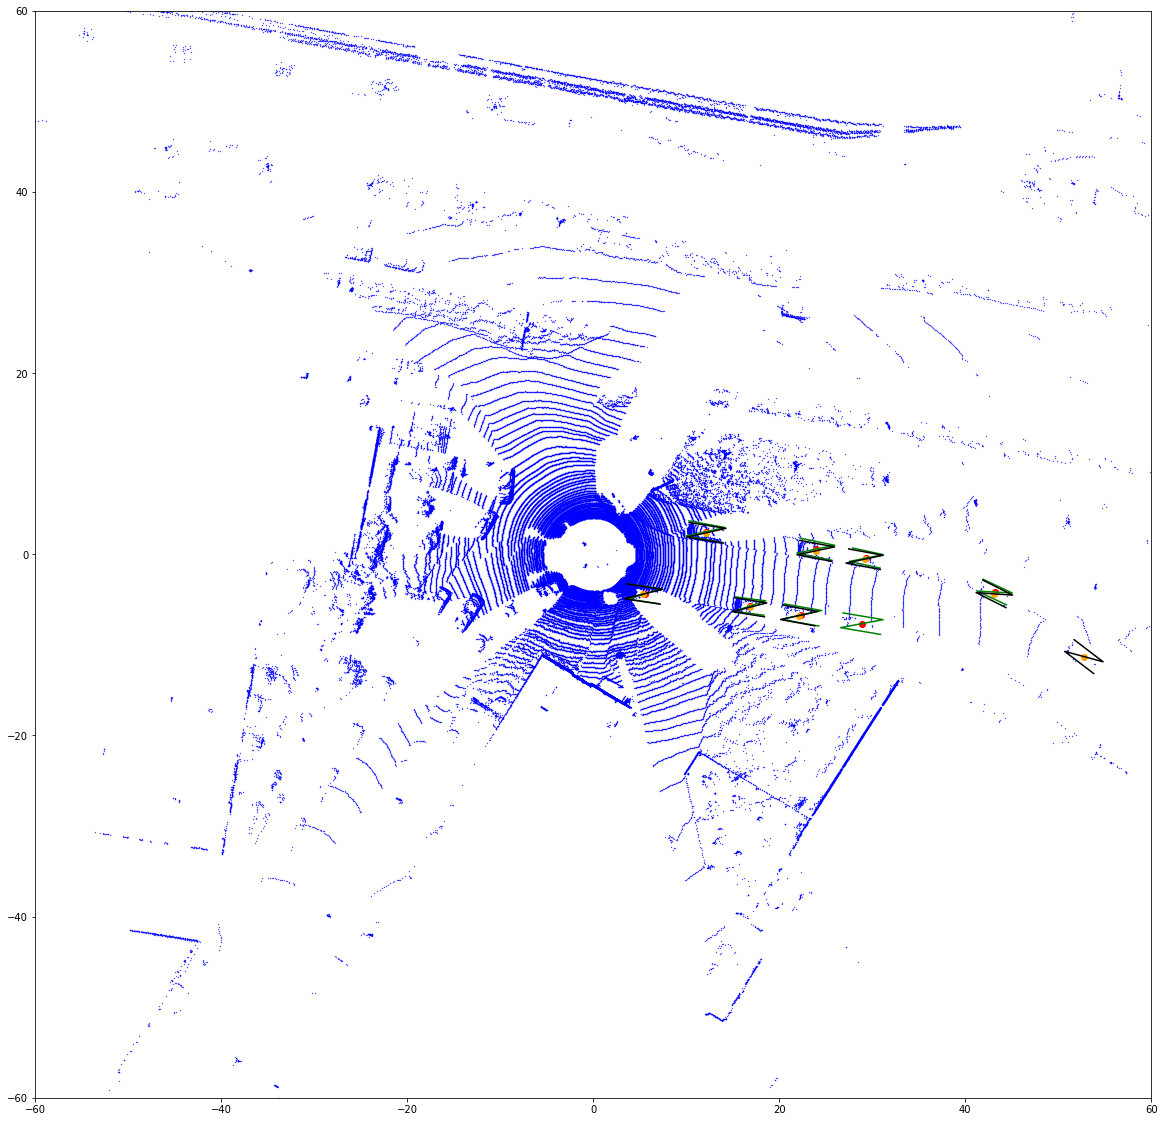

In [105]:
kitti_reader = KITTIReader('../kitti_dataset/training/')
xyzi, img, calib, labels = kitti_reader.read_sample('000010')

plt.figure(figsize=(20, 20))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c='blue',  s=0.1)
gt_boxes, pred_boxes = [], []
for label_type, label_alpha, label_box, label_size, label_location, label_box, label_ry in labels:
    if label_type not in VEHICLE_CLASSES:
        continue
    velo_loc = calib.project_ref_to_velo(np.expand_dims(label_location, 0))[0]
    plt.scatter([velo_loc[0]], [velo_loc[1]], c='red')
    _, w, l = label_size
    b = Box(velo_loc[:2], w, l, label_ry)
    plt.plot(b.corners[:, 0], b.corners[:, 1], c='green')
    gt_boxes.append(b)

scene = pipeline_detector.predict(xyzi, img, calib)
for detection in scene.detections:
    velo_loc = calib.project_ref_to_velo(np.expand_dims(detection.xyz, 0))[0]
    plt.scatter([velo_loc[0]], [velo_loc[1]], c='orange')
    l, w, _ = detection.lwh
    b = Box(velo_loc[:2], w, l, detection.angle)
    plt.plot(b.corners[:, 0], b.corners[:, 1], c='black')
    pred_boxes.append(b)
    
plt.xlim((-60, 60))
plt.ylim((-60, 60))
plt.show()

In [89]:
from tqdm import tqdm


def calc_true_scores(dataset, pipeline_detector, iou_threshold):
    n_fns = 0
    true_scores, fp_scores = [], []
    for sid in tqdm(dataset.get_sample_ids()):
        xyzi, img, calib, labels = dataset.read_sample(sid)
        gt_boxes, pred_boxes = [], []
        for label_type, label_alpha, label_box, label_size, label_location, label_box, label_ry in labels:
            if label_type not in VEHICLE_CLASSES:
                continue
            velo_loc = calib.project_ref_to_velo(np.expand_dims(label_location, 0))[0]
            _, w, l = label_size
            b = Box(velo_loc[:2], w, l, label_ry)
            gt_boxes.append(b)

        scene = pipeline_detector.predict(xyzi, img, calib)
        for detection in scene.detections:
            velo_loc = calib.project_ref_to_velo(np.expand_dims(detection.xyz, 0))[0]
            l, w, _ = detection.lwh
            b = Box(velo_loc[:2], w, l, detection.angle)
            pred_boxes.append(b)
        tp, fp, fn = match_boxes(pred_boxes, gt_boxes, iou_threshold)
        for pred_index, _ in tp:
            true_scores.append(scene.detections[pred_index].confidence)
        for pred_index in fp:
            fp_scores.append(scene.detections[pred_index].confidence)
        n_fns += len(fn)
    return np.array(true_scores), np.array(fp_scores), n_fns

In [73]:
def calc_prs(true_scores, fp_scores, n_fns):
    thresholds = sorted(set(true_scores) | set(fp_scores))
    thresholds.append(float('inf'))
    thresh_metrics = []
    for threshold in thresholds:
        tp = np.sum(true_scores >= threshold)
        fn = n_fns + len(true_scores) - tp
        fp = np.sum(fp_scores >= threshold)
        precision = 0. if tp == 0 else float(tp) / (tp + fp)
        recall = 0. if tp == 0 else float(tp) / (tp + fn)
        thresh_metrics.append((threshold, precision, recall))
    return thresh_metrics


def average_precision(thresh_prs):
    _, _, prev_recall = thresh_prs[-1]
    ap = 0.
    for _, precision, recall in thresh_prs[-2::-1]:
        ap += precision * (recall - prev_recall)
        prev_recall = recall
    return ap

In [106]:
true_scores, fp_scores, n_fns = calc_true_scores(kitti_reader, pipeline_detector, .7)

100%|██████████| 1000/1000 [1:13:25<00:00,  4.41s/it]


In [107]:
thresh_prs = calc_prs(true_scores, fp_scores, n_fns)

average_precision(thresh_prs)

0.33160659853088326

In [35]:
xyzi = np.fromfile('../kitti_dataset/training/velodyne/000100.bin', dtype=np.float32).reshape(-1, 4)

(-50, 50)

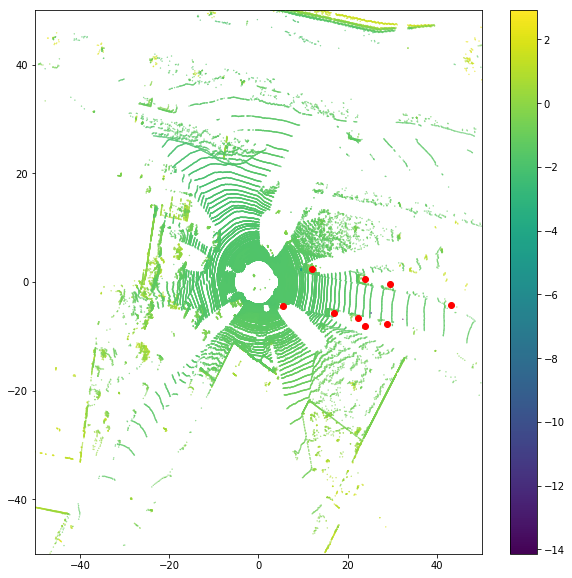

In [129]:
plt.figure(figsize=(10, 10))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
for lablel_type, label_box, label_location in labels:
    vl = calib.project_ref_to_velo(np.expand_dims(label_location, 0))
    plt.scatter([vl[0, 0]], [vl[0, 1]], c='red')
plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [434]:
from IPython.display import Image

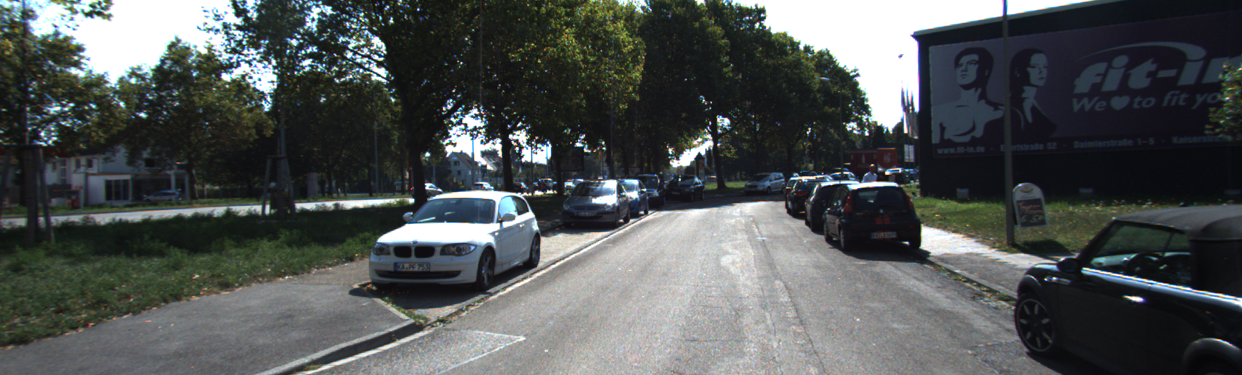

In [436]:
Image('../kitti_dataset/training/image_2/000010.png')

In [ ]:
with open('../kitti_dataset/training/calib/000100.txt') as f:
    print f.read()

In [ ]:
with open('../kitti_dataset/training/label_2/000100.txt') as f:
    print f.read()